In [1]:
import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="white", palette="muted")
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def load_log(filename):
    """Load data from logs with estimated acceleration. Returns
    a numpy record array.
    """
    datatype = np.dtype([
        ('time', '<f8'),
        ('kistler_torque', '<f8'),
        ('motor_torque', '<f8'),
        ('feedback_reference', '<f8'),
        ('estimated_position', '<f8'),
        ('estimated_velocity', '<f8'),
        ('estimated_acceleration', '<f8'),
    ])
    
    values = []
    with open(filename) as f:
        for line in f:
            vals = tuple(float(f) for f in line.split(','))
            assert(len(vals) == len(datatype))
            # check if time is valid,
            # there is usually an invalid time within the first 5 iterations
            if vals[0] > 2**32 - 1:
                assert len(values) <= len(datatype)*5, 'invalid time after {} iterations'.format(
                    len(values)//len(datatype))
                values = []
                continue
            values.append(vals)
    data = np.rec.array(values, dtype=datatype)
    t = data.time
    dt = np.diff(t)
    offset = 2**32 * np.cumsum(dt < 0)
    data.time[1:] += offset
    data.time -= data.time[0]
    data.time /= 168e6 # real time clock frequency
    return data

In [3]:
def plot_log(record, normalize_plot=True, show_plot=True):
    colors = sns.husl_palette(8)
    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    if normalize_plot:
        norm = lambda x: np.abs(x).max()
        normalize = lambda x: x/norm(x)
        normalize_label = lambda x, l: '{}/{}'.format(l, norm(x))
    else:
        norm = lambda x: 1
        normalize = lambda x: x
        normalize_label = lambda x, l: l
    ax[0].plot(record.time, normalize(record.estimated_position),
               color=colors[0], label=normalize_label(record.estimated_position,
                                                      'estimated position'))
    ax[0].plot(record.time, normalize(record.estimated_velocity),
               color=colors[1], label=normalize_label(record.estimated_velocity,
                                                      'estimated velocity'))
    ax[0].plot(record.time, normalize(record.estimated_acceleration),
               color=colors[2], label=normalize_label(record.estimated_acceleration,
                                                      'estimated acceleration'))
    ax[0].plot(record.time, record.feedback_reference/norm(record.estimated_velocity),
               zorder=1, alpha=0.7,
               color=colors[3], label=normalize_label(record.estimated_velocity,
                                                     'feedback velocity'))
    ax[0].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad, rad/s, rad/s^2]')
    
    inertia = 0.00592455 # kg-m^2
    inertia_torque = inertia*record.estimated_acceleration;
    steer_torque = record.kistler_torque + record.motor_torque + inertia_torque
    ax[1].plot(record.time, record.kistler_torque, color=colors[4], label='sensor torque')
    ax[1].plot(record.time, record.motor_torque, color=colors[5], label='motor torque')
    ax[1].plot(record.time, inertia_torque, color=colors[6], label='inertia torque (calculated)',
               zorder=1, alpha=0.7)
    ax[1].plot(record.time, steer_torque, color=colors[7], label='steer torque (calculted)',
               zorder=1, alpha=0.7)
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('torque [N-m]')
    ax[1].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    if show_plot:
        plt.show()
    return fig, ax

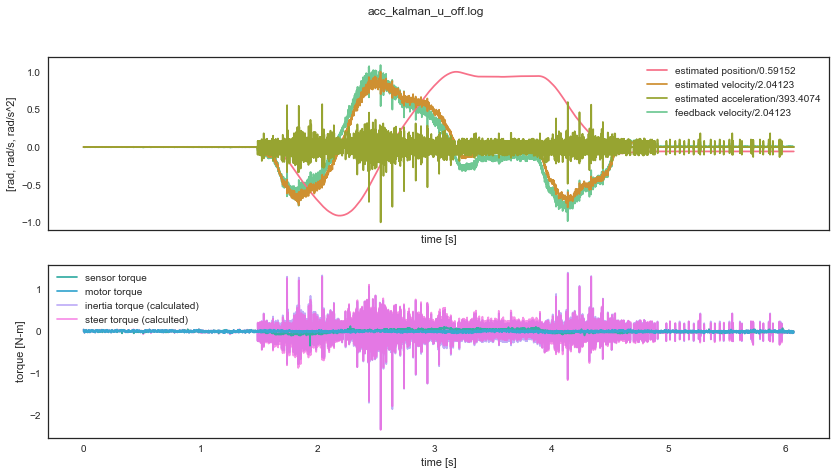

In [4]:
vals = load_log('acc_kalman_u_off.log')
fig, ax = plot_log(vals, show_plot=False)
fig.suptitle('acc_kalman_u_off.log')
plt.show()

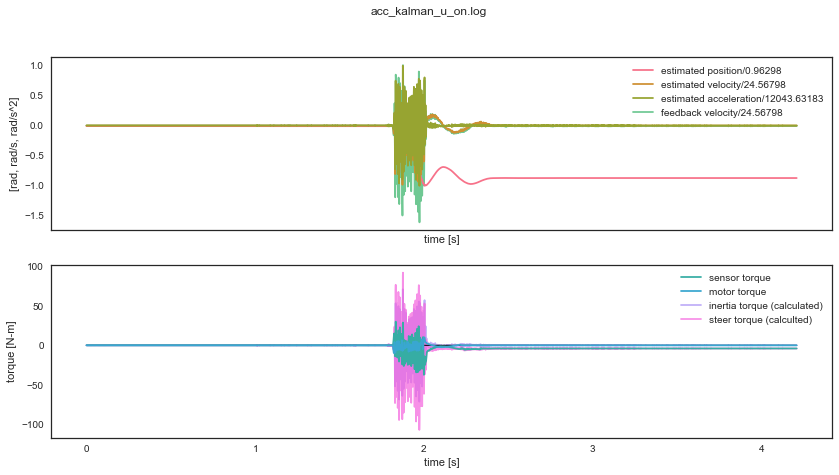

In [5]:
vals = load_log('acc_kalman_u_on.log')
fig, ax = plot_log(vals, show_plot=False)
fig.suptitle('acc_kalman_u_on.log')
plt.show()

In [6]:
def display_log_plot(filename, polyfit_window, normalize_plot=True):
    vals = load_log(filename)
    fig, ax = plot_log(vals, normalize_plot=normalize_plot, show_plot=False)
    try:
        title = '{}\npolyfit window {} order {}'.format(filename, polyfit_window, 3)
        mpld3
    except NameError:
        ax[0].set_title(title)
    else:
        fig.suptitle(title)
    plt.show()

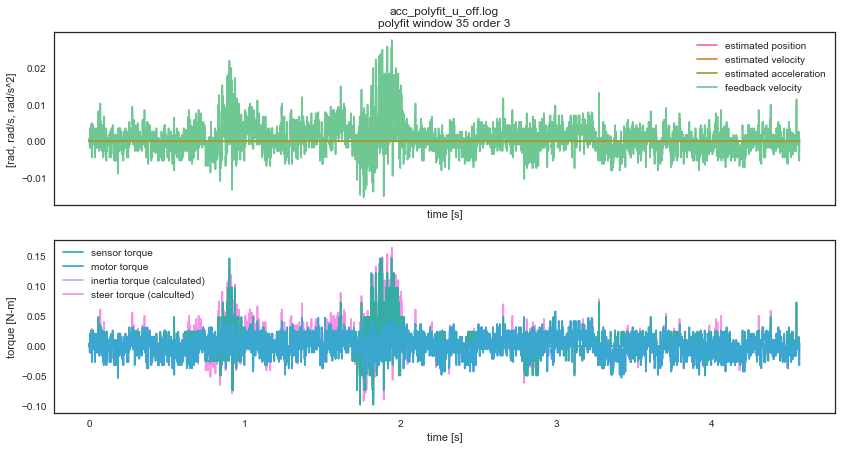

In [7]:
display_log_plot('acc_polyfit_u_off.log', 35, False)

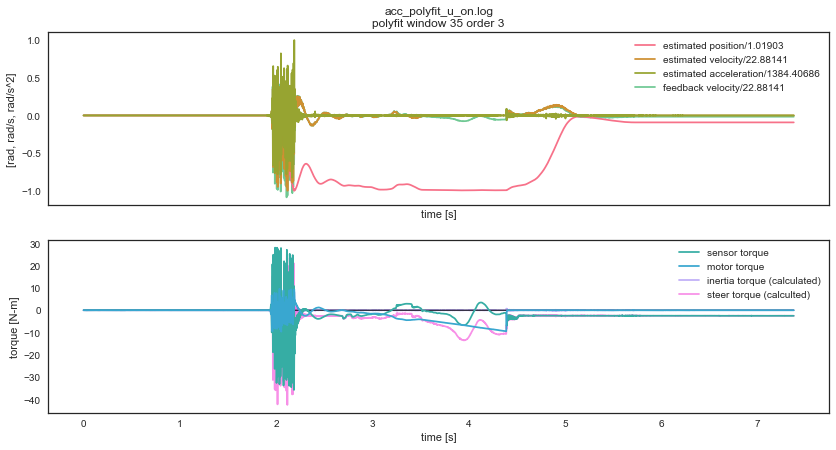

In [8]:
display_log_plot('acc_polyfit_u_on.log', 35)

In [ ]:
display_log_plot('acc_polyfit_u_off2.log', 35)